# Production-Grade Multi Horizon Time Series Forecasting System with Concept Drift Detection
# Session 1: Data Exploration

## Objective
Understand the structure, temporal patterns, and data quality of the M5 dataset
to enable robust multi-horizon forecasting and drift-aware modeling.

## Key Questions
- What does one observation represent?
- How does demand vary across time, products, and stores?
- What seasonality and trends exist?
- Where can leakage or non-stationarity arise?


## Why Forecasting Systems Fail in Production

Most real-world demand forecasting systems fail not because of poor models, but due to structural issues in the data and environment. The most common failure modes include:

- **Non-stationarity**: Demand patterns evolve over time due to consumer behavior, pricing, and external shocks.
- **Concept Drift**: The relationship between features (calendar, price, promotions) and demand changes silently.
- **Regime Changes**: Holidays, promotions, and rare events create demand regimes unseen during training.
- **Scale Heterogeneity**: High-volume items and slow-moving items exhibit fundamentally different dynamics.
- **Horizon Instability**: Models performing well at short horizons often degrade rapidly at longer horizons.

This project is explicitly designed to address these failure modes through adaptive modeling, horizon-aware evaluation, and drift-sensitive decision logic rather than relying on a single static forecasting model.

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL

In [2]:
plt.style.use("seaborn-v0_8")
sns.set_context("talk")

#### Load the Data

In [3]:
calendar = pd.read_csv("calendar.csv")
prices   = pd.read_csv("sell_prices.csv")
sales    = pd.read_csv("sales_train_validation.csv")

#### First Look

In [4]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [6]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [7]:
print("calendar: ",calendar.shape)
print("prices: ",prices.shape)
print("sales: ",sales.shape)

calendar:  (1969, 14)
prices:  (6841121, 4)
sales:  (30490, 1919)


## Forecast Horizon and Problem Framing

Although the M5 Accuracy dataset evaluates forecasts over a fixed 28-day horizon, forecasting difficulty is not uniform across time steps.

Key considerations:
- **Short-term forecasts (t+1 to t+7)** are dominated by local autocorrelation and recent trends.
- **Mid-term forecasts (t+8 to t+21)** require stable seasonal structure.
- **Long-term forecasts (t+22 to t+28)** are highly uncertain and sensitive to regime shifts.

A model optimized for short horizons is not guaranteed to perform well at longer horizons. Therefore, this project treats forecasting as a **multi-horizon problem**, laying the foundation for horizon-aware evaluation and model selection in later stages.

#### From all columns whose names start with d_, finding the minimum and maximum sales value across the entire dataset.

In [8]:
print("For every column that starts with 'd_': ")
print("Minimum sales: ",sales.filter(regex="^d_").values.min())
print("Maximum sales: ",sales.filter(regex="^d_").values.max())

For every column that starts with 'd_': 
Minimum sales:  0
Maximum sales:  763


#### Observations:                              

- Many zeros → intermittent demand

- Non-negative integers

- Sparse for some items

#### Implication for modeling:

- MAPE will be unstable

- Zero-heavy distributions

- Consider robust metrics later

#### current problems:

- sales DataFrame is in wide format:
- it is:
  - Hard to join with time features
  - Not how time-series algorithms think
  - Not scalable for feature engineering
  - Awkward for EDA and plotting

#### Convert to Long Format using .melt()

In [9]:
sales_long = sales.melt(
    id_vars = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    var_name = "d",
    value_name = "sales"
)

In [10]:
sales_long.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [11]:
# Merge calender

sales_long = sales_long.merge(calendar[["d", "date", "wday", "month", "year"]], on="d")
sales_long["date"] = pd.to_datetime(sales_long["date"])

In [12]:
sales_long.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wday,month,year
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,1,1,2011


#### Global Demand Over Time (Sanity Check)

In [13]:
daily_sales =(
    sales_long
    .groupby("date")["sales"]
    .sum()
    .reset_index()
)

In [14]:
daily_sales.head(1)

,date,sales
0,2011-01-29,32631


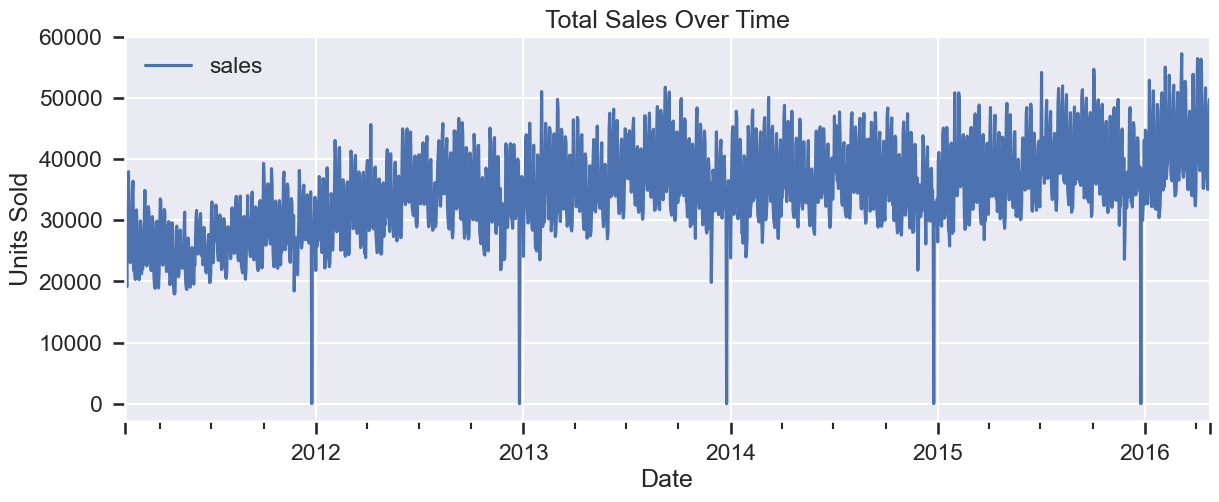

In [15]:
fig , ax = plt.subplots(figsize=(14,5))
daily_sales.plot(x = "date", y = "sales", ax=ax)
ax.set_title("Total Sales Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Units Sold")
plt.show()

## Quantifying Seasonality Strength

Visual inspection suggests the presence of weekly and annual seasonal patterns across many item–store combinations. However, relying solely on visual intuition can be misleading.

To guide downstream modeling decisions, we quantify seasonality strength using decomposition-based measures. This allows us to:
- Distinguish between strongly seasonal and weakly seasonal series
- Justify the inclusion of classical time-series models
- Avoid blindly applying complex models where seasonality is weak or unstable

Seasonality strength will later be used as an input signal for adaptive model selection.

#### Seasonality Analysis (Weekly & Yearly)

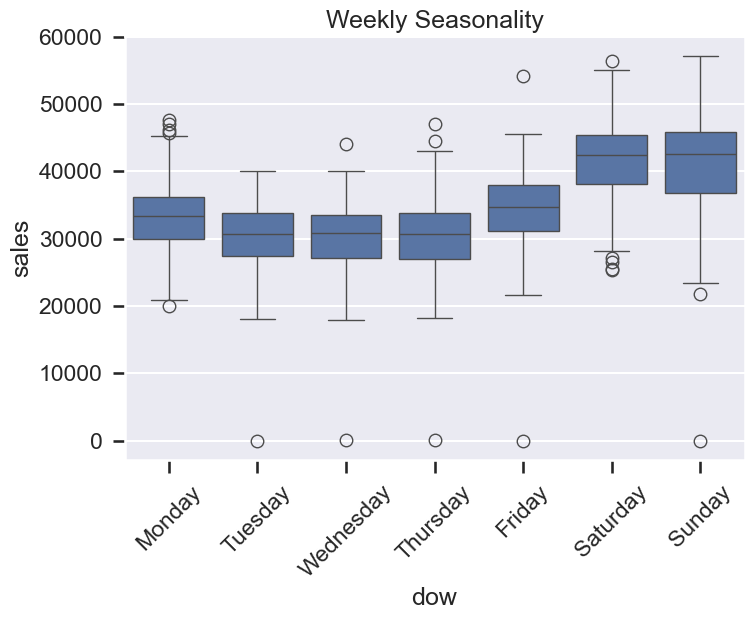

In [16]:
daily_sales["dow"] = daily_sales["date"].dt.day_name()

ax = sns.boxplot(
    data = daily_sales,
    x = "dow",
    y = "sales",
    order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
ax.set_title("Weekly Seasonality")
ax.tick_params(axis = "x", rotation = 45)
plt.show()

#### Business interpretation:

- Weekends sales ≠ weekdays sales

- Models must encode calendar effects

#### STL Decomposition (Seasonal–Trend decomposition using LOESS)

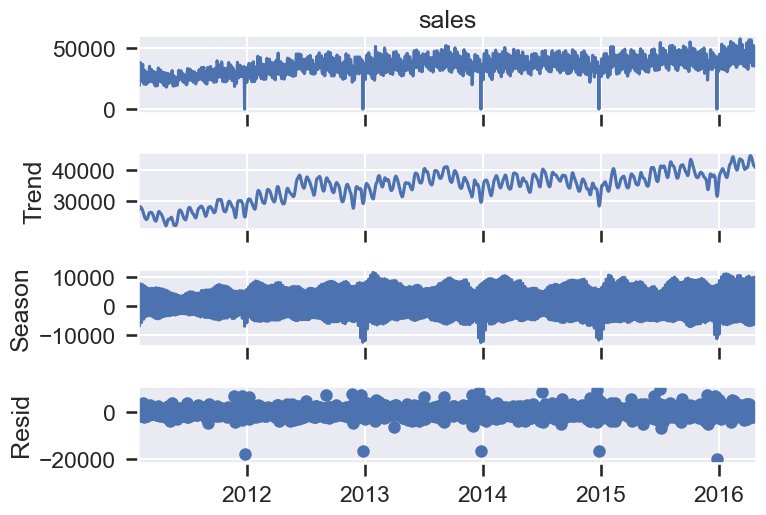

In [17]:
stl = STL(daily_sales.set_index("date")["sales"], period=7)
res = stl.fit()

res.plot()
plt.show()

## Demand Sparsity and Intermittency Analysis

Retail demand data is characterized by significant sparsity, especially at the item–store level.

Key observations:
- Many series exhibit a high proportion of zero-sales days
- Mean demand varies by several orders of magnitude across items
- Coefficient of variation is high for slow-moving products

These properties indicate **intermittent demand behavior**, where standard regression-based or deep learning models may overfit or produce unstable forecasts.

As a result, model choice must explicitly account for sparsity and variability rather than assuming homogeneous demand dynamics across series.

## Common Pitfalls Avoided

-  Random train-test split (causes leakage)
-  Ignoring zero-heavy demand
-  Modeling without calendar effects
-  Evaluating on aggregated data only

## Summary - Key EDA Insights

1. Demand shows strong weekly seasonality and long-term trend.
2. Significant non-stationarity exists → rolling validation required.
3. High sparsity at item level → naive MAPE unsuitable.
4. Calendar effects are critical explanatory variables.
5. 
Based on exploratory analysis and problem framing, the following design decisions are fixed for subsequent stages of the project:

- **Dataset**: M5 Forecasting – Accuracy version
- **Forecasting Horizon**: 28 days, treated as a multi-horizon problem
- **Granularity**: Item–Store–Day level
- **Key Challenges Identified**:
  - Non-stationarity and concept drift
  - Strong heterogeneity across series
  - Demand sparsity and intermittency
- **Modeling Philosophy**:
  - No single model will perform best across all regimes
  - Adaptive, horizon-aware, and drift-sensitive forecasting is required

In [21]:
from pathlib import Path
import sys

# Find project root robustly
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "config").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.append(str(PROJECT_ROOT))

from config.paths import DATA_DIR

DATA_DIR.mkdir(parents=True, exist_ok=True)

daily_sales.to_parquet(
    DATA_DIR / "daily_sales.parquet",
    index=False
)

In [22]:
print(DATA_DIR)
print((DATA_DIR / "daily_sales.parquet").exists())

C:\Jupyter Notebook\PROJECTS\Multi_Horizon_Time_Series_Forecasting_System_with_Concept_Drift_Detection\data\processed
True
